In [2]:
import os
import sys
import numpy as np
import nibabel as nib
import pandas as pd
from sklearn import svm
from sklearn.pipeline import Pipeline
import os.path
from sklearn.model_selection import RepeatedStratifiedKFold, cross_validate, permutation_test_score, StratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score,make_scorer
from copy import deepcopy
import argparse

from core_classification_functions import *
current_path = os.getcwd()
from mixed_sigmoid_normalisation import MixedSigmoidScaler

data_path="/Users/abry4213/data/fMRI_classification/"

%load_ext rpy2.ipython

In [3]:
%%R
# Load tidyverse R package
suppressPackageStartupMessages({
    library(tidyverse)
    library(see)
    library(cowplot)
    theme_set(theme_cowplot())
})

In addition: Warning message:
package ‘see’ was built under R version 4.3.3 


In [22]:
# Load main balanced accuracy results
univariate_p_values = pd.read_feather(f"{data_path}/classification_results/univariate_p_values.feather")
pairwise_p_values = pd.read_feather(f"{data_path}/classification_results/pairwise_p_values.feather")
combined_univariate_pairwise_p_values = pd.read_feather(f"{data_path}/classification_results/combined_univariate_pairwise_p_values.feather")
all_p_value_results = pd.concat([univariate_p_values, pairwise_p_values, combined_univariate_pairwise_p_values])

# Load confound classification results
age_sex_FD_predicting_dx_balanced_accuracy_results = pd.read_feather(f"{data_path}/classification_results/confound_analysis/age_sex_FD_predicting_dx_balanced_accuracy_results.feather")
age_sex_FD_predicting_dx_balanced_accuracy_results_all_folds = pd.read_feather(f"{data_path}/classification_results/confound_analysis/age_sex_FD_predicting_dx_balanced_accuracy_results_all_folds.feather")

# Load results combining confounds PLUS fMRI time-series features
features_plus_confounds_balanced_accuracy_results = pd.read_feather(f"{data_path}/classification_results/confound_analysis/feature_based_models_with_age_sex_FD_main_classification_res.feather")
features_plus_confounds_balanced_accuracy_results_all_folds = pd.read_feather(f"{data_path}/classification_results/confound_analysis/feature_based_models_with_age_sex_FD_main_classification_res_all_folds.feather")

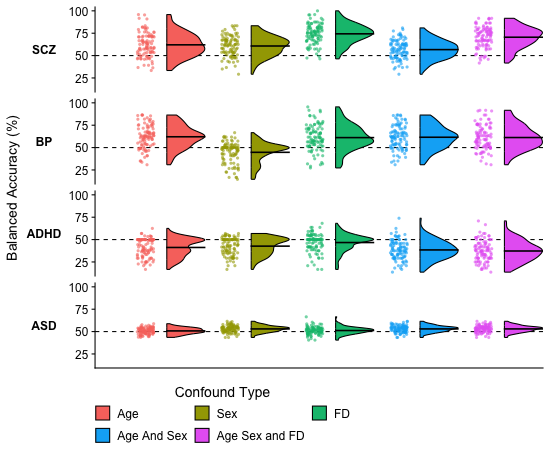

In [23]:
%%R -i age_sex_FD_predicting_dx_balanced_accuracy_results_all_folds  -w 550 -h 450

age_sex_FD_predicting_dx_balanced_accuracy_results_all_folds %>% 
       mutate(Analysis_Type = ifelse(Analysis_Type == "Mean FD Power", "FD", Analysis_Type)) %>%
    mutate(Analysis_Type = factor(Analysis_Type, levels=c("Age", "Sex", "FD", "Age And Sex", "Age Sex and FD")),
           Disorder = factor(Disorder, levels=c("SCZ", "BP", "ADHD", "ASD"))) %>%
    ggplot(data=., mapping=aes(x=Analysis_Type, y=100*Balanced_Accuracy, fill=Analysis_Type, color=Analysis_Type)) +
    geom_hline(yintercept=50, linetype="dashed", color="black") +
    geom_violinhalf(scale="width", color="black", position = position_nudge(x=0.25))  +
    stat_summary(color="black", fun="mean", geom="crossbar", width=0.465, linewidth=0.3, 
            show.legend=FALSE, position = position_nudge(x=0.475)) +
    geom_point(position = position_jitter(width = 0.1),
                size = 1.5, alpha=0.6, stroke=0) +
    facet_grid(Disorder ~ ., scales="free", switch="both") +
    ylab("Balanced Accuracy (%)") +
    labs(fill="Confound Type", color="Confound Type") + 
    guides(fill=guide_legend(nrow=2,byrow=TRUE, title.position="top", title.hjust = 0.5),
           color=guide_legend(nrow=2,byrow=TRUE, title.position="top", title.hjust = 0.5)) +
    theme(legend.position = "bottom", axis.ticks.x = element_blank(), 
          strip.background = element_blank(),
          strip.placement = "outside",
          strip.text.y.left = element_text(angle=0, face="bold"), 
          axis.text.x = element_blank(), 
          axis.title.x = element_blank()) 
# ggsave("../../plots/confound_analysis/Age_Sex_FD_classification_performances.png", width=7, height=6, units="in", dpi=300)

In [7]:
features_plus_confounds_balanced_accuracy_results_all_folds.head()

,index,Study,Disorder,Analysis_Type,group_var,Balanced_Accuracy,Fold,Repeat
0,0,UCLA_CNP,SCZ,Brain_Region,Left-Accumbens-area,0.575000,0,0
1,1,UCLA_CNP,SCZ,Brain_Region,Left-Accumbens-area,0.733333,1,0
2,2,UCLA_CNP,SCZ,Brain_Region,Left-Accumbens-area,0.833333,2,0
3,3,UCLA_CNP,SCZ,Brain_Region,Left-Accumbens-area,0.591667,3,0
4,4,UCLA_CNP,SCZ,Brain_Region,Left-Accumbens-area,0.708333,4,0


In [34]:
# Combine the results

all_p_values_here = (all_p_value_results
                     .rename(columns={"Balanced_Accuracy": "Features_Only"})
                     .assign(Analysis_Type = lambda x: np.where(x.Analysis_Type == "SPI", "pyspi14_SPI", x.Analysis_Type))
                     .filter(["group_var", "Analysis_Type", "Disorder", "Study", "Features_Only", "p_value_BenjaminiHochberg"])
)

confound_balanced_accuracy_results_here = (age_sex_FD_predicting_dx_balanced_accuracy_results
                                           .query("Analysis_Type in ['Age And Sex', 'Age Sex and FD']")
                                           .pivot(index=['Study', 'Disorder'], columns='Analysis_Type', values='Balanced_Accuracy')
                                           .rename(columns={"Age And Sex": "Age_and_Sex", "Age Sex and FD": "Age_Sex_FD"})
                                           .reset_index())

features_plus_confounds_balanced_accuracy_results_here = (features_plus_confounds_balanced_accuracy_results
                                                          .pivot(index=['Study', 'Disorder', 'Analysis_Type', 'group_var'], columns='Confounds', values='Balanced_Accuracy')
                                                          .reset_index()
                                                          .rename(columns={"Age+Sex": "Age_Sex_Features", "Age+Sex+FD": "Age_Sex_FD_Features"}))

# Merge the results
all_results_merged = pd.merge(features_plus_confounds_balanced_accuracy_results_here, 
                              all_p_values_here, 
                              on=["group_var", "Study", "Disorder", "Analysis_Type"], 
                              how="left").merge(confound_balanced_accuracy_results_here, how="left").drop(columns=["p_value_BenjaminiHochberg"])

all_results_merged.head()

,Study,Disorder,Analysis_Type,group_var,Age_Sex_Features,Age_Sex_FD_Features,Features_Only,Age_and_Sex,Age_Sex_FD
0,ABIDE,ASD,Brain_Region,Angular_Gyrus,0.489225,0.487063,0.464773,0.52977,0.52977
1,ABIDE,ASD,Brain_Region,Central_Opercular_Cortex,0.528845,0.525672,0.516732,0.52977,0.52977
2,ABIDE,ASD,Brain_Region,Cingulate_Gyrus_anterior_division,0.522404,0.516590,0.522574,0.52977,0.52977
3,ABIDE,ASD,Brain_Region,Cingulate_Gyrus_posterior_division,0.520302,0.519186,0.522027,0.52977,0.52977
4,ABIDE,ASD,Brain_Region,Cuneal_Cortex,0.524585,0.531981,0.519720,0.52977,0.52977


In [39]:
%%R -i all_results_merged

all_results_merged %>% 
    pivot_longer(cols=c(Age_and_Sex, Age_Sex_FD, Features_Only, Age_Sex_Features, Age_Sex_FD_Features), 
                 names_to = "Model_Type", values_to="Balanced_Accuracy") %>% 
    mutate(Analysis_Type = ifelse(Analysis_Type == "pyspi14_SPI", "SPI", Analysis_Type)) %>%
    mutate(Model_Type = factor(Model_Type, levels = c("Age_and_Sex", "Age_Sex_FD", "Features_Only", "Age_Sex_Features", "Age_Sex_FD_Features")),
           Disorder = factor(Disorder, levels = c("SCZ", "BP", "ADHD", "ASD")),
           Analysis_Type = factor(Analysis_Type, levels = c("Brain_Region", "catch25_feature", 
                                                            "Univariate_Combo", "SPI", "SPI_Combo"))) %>%
    ggplot(data=., mapping=aes(x=Model_Type, y=100*Balanced_Accuracy, group=group_var)) +
    geom_hline(yintercept=50, linetype=2) +
    facet_grid(Analysis_Type ~ Disorder, scales="free_x", switch="y") +
    geom_line(alpha=0.2, linewidth=0.4) +
    ylab("Balanced Accuracy (%)") +
    labs(color = "Model Type") +
    geom_point(aes(color=Model_Type), alpha = 0.8, stroke = 0, size = 2.5) + 
    scale_color_manual(values = c("Age_and_Sex" = "#A78EE5", 
                                  "Age_Sex_FD"="#4DBCE2", 
                                  "Features_Only" = "#9CCF65",
                                  "Age_Sex_Features" = "#F5C851",
                                  "Age_Sex_FD_Features" = "#E75361")) +
    scale_x_discrete(expand=c(0.1,0)) +
    theme(legend.position="bottom",
            strip.background = element_blank(),
            axis.text.x = element_blank(), 
            axis.title.x = element_blank(),
            axis.ticks.x = element_blank(),
            strip.placement='outside')  +
    guides(color=guide_legend(nrow=2,byrow=TRUE))

# ggsave("../../plots/confound_analysis/Age_Sex_and_FD_with_without_feature_performance.svg", width=6.5, height=8.5, units="in", dpi=300)